In [1]:
!pip install -q tf-nightly

In [2]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import pathlib
import random
import IPython.display as display

from IPython import display

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
cartoon_image_path = os.listdir('../input/cartoonfacedatasetzip/cartoon_face_dataset/cartoonset10k')
cartoon_image_path = [os.path.join("../input/cartoonfacedatasetzip/cartoon_face_dataset/cartoonset10k", x) for x in cartoon_image_path]

cim = []
for x in cartoon_image_path:
    if x[-3:]=='png':
        cim.append(x)
cartoon_image_path = cim
len(cartoon_image_path)

10000

In [5]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    #image = ndi.gaussian_filter(image, 5)
    image = tf.image.resize_images(image, [58, 58])
    image = tf.image.central_crop(central_fraction=0.55, image=image)
    #image = tf.image.rgb_to_grayscale(image)
    image -= 127.5
    image /= 127.5  # normalize to [-1,1] range
    return image

def load_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

In [6]:
cartoon_path_ds = tf.data.Dataset.from_tensor_slices(cartoon_image_path)
cartoon_image_ds = cartoon_path_ds.map(load_image, num_parallel_calls=AUTOTUNE)

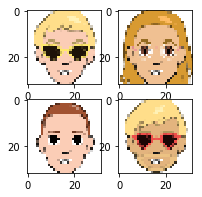

(32, 32, 3)


In [7]:
def show_images(images, l=2, epoch=-1):
    plt.figure(figsize=(l*1.5,l*1.5))
    for n,image in enumerate(images):
        image = (image + 1 ) / 2 #scale to [0,1]
        plt.subplot(l,l,n+1)
        plt.imshow(image)
        plt.grid(False)
    plt.show()
    print(image.shape)
    if epoch!=-1:
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
show_images(cartoon_image_ds.take(4))

In [8]:
cartoon_BATCH_SIZE = 32
cartoon_ds = cartoon_image_ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=len(cartoon_image_path)))
cartoon_ds = cartoon_ds.batch(cartoon_BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
cartoon_ds = cartoon_ds.prefetch(buffer_size=AUTOTUNE)
cartoon_ds

<DatasetV1Adapter shapes: (?, 32, 32, 3), types: tf.float32>

In [9]:
for cartoon in cartoon_ds:
    test_cartoon = cartoon
    break
    
print(test_cartoon.shape)

(32, 32, 32, 3)


In [10]:
test_cartoon = test_cartoon[:4]

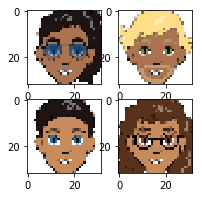

(32, 32, 3)


In [11]:
show_images(test_cartoon)

In [12]:
print(np.max(test_cartoon))
print(np.min(test_cartoon))

1.0
-1.0


In [13]:
def make_generator_model():
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Reshape((4, 4, 512)))
    
    model.add(tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

In [14]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              819200    
_________________________________________________________________
batch_normalization_v1 (Batc (None, 8192)              32768     
_________________________________________________________________
re_lu (ReLU)                 (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 256)         3276800   
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 4, 4, 256)         1

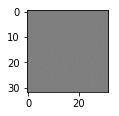

(32, 32, 3)


In [15]:
noise_dim = 100
noise = tf.random_normal([1, noise_dim])
gen_out = generator(noise)
show_images(gen_out, l=1)

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(32,32,3)))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.3))
      
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.3))
       
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    #model.add(tf.keras.layers.Activation('sigmoid'))

    return model

In [17]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 128)        

In [18]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [19]:
def discriminator_loss(real_out, generated_out):
    real_loss = tf.losses.sigmoid_cross_entropy(tf.ones_like(real_out), real_out)
    generated_loss = tf.losses.sigmoid_cross_entropy(tf.zeros_like(generated_out), generated_out)
    total_loss = real_loss + generated_loss
    return total_loss

In [20]:
g_optimizer = tf.train.AdamOptimizer(1e-3, beta1=0.5)
d_optimizer = tf.train.AdamOptimizer(1e-3, beta1=0.5)

In [21]:
2.5e-4

0.00025

In [22]:
noise_dim = 100
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 noise_dim])

In [23]:
'''def train_step(cartoon_images):
    
    noises = tf.random_normal([cartoon_BATCH_SIZE, noise_dim])
    for noise, cartoon_image in zip(noises, cartoon_images):
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:

            # generating noise from a normal distribution

            generated_image = generator(noise, training = True)

            real_out = discriminator(cartoon_image, training =True)
            generated_out = discriminator(generated_image, training = True)

            gen_loss = generator_loss(generated_out)
            dis_loss = discriminator_loss(real_out, generated_out)

        gen_grad = gen_tape.gradient(gen_loss, generator.variables)
        dis_grad = dis_tape.gradient(dis_loss, discriminator.variables)

        g_optimizer.apply_gradients(zip(gen_grad, generator.variables))
        d_optimizer.apply_gradients(zip(dis_grad, discriminator.variables))
'''

'def train_step(cartoon_images):\n    \n    noises = tf.random_normal([cartoon_BATCH_SIZE, noise_dim])\n    for noise, cartoon_image in zip(noises, cartoon_images):\n        \n        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:\n\n            # generating noise from a normal distribution\n\n            generated_image = generator(noise, training = True)\n\n            real_out = discriminator(cartoon_image, training =True)\n            generated_out = discriminator(generated_image, training = True)\n\n            gen_loss = generator_loss(generated_out)\n            dis_loss = discriminator_loss(real_out, generated_out)\n\n        gen_grad = gen_tape.gradient(gen_loss, generator.variables)\n        dis_grad = dis_tape.gradient(dis_loss, discriminator.variables)\n\n        g_optimizer.apply_gradients(zip(gen_grad, generator.variables))\n        d_optimizer.apply_gradients(zip(dis_grad, discriminator.variables))\n'

In [24]:
def train_step(cartoon_images):
            
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:

        noise = tf.random_normal([cartoon_BATCH_SIZE, noise_dim])
        # generating noise from a normal distribution
        generated_images = generator(noise, training = True)

        real_out = discriminator(cartoon_images, training = True)
        generated_out = discriminator(generated_images, training = True)

        gen_loss = generator_loss(generated_out)
        dis_loss = discriminator_loss(real_out, generated_out)

    gen_grad = gen_tape.gradient(gen_loss, generator.variables)
    dis_grad = dis_tape.gradient(dis_loss, discriminator.variables)

    g_optimizer.apply_gradients(zip(gen_grad, generator.variables))
    d_optimizer.apply_gradients(zip(dis_grad, discriminator.variables))


In [25]:
train_step = tf.contrib.eager.defun(train_step)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [26]:
def generate_test_prediction(model, epoch, test_input):
    # make sure the training parameter is set to False because we
    # don't want to train the batchnorm layer when doing inference.
    
    gen_out = generator(test_input, training=False)
    show_images(gen_out, 4, epoch=epoch)
    #print(discriminator(gen_out[:4]))
    #print(discriminator(test_cartoon))
    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

In [27]:
gen_out = generator(random_vector_for_generation, training=False)
print(np.max(gen_out))
print(np.min(gen_out))

0.026612423
-0.023172552


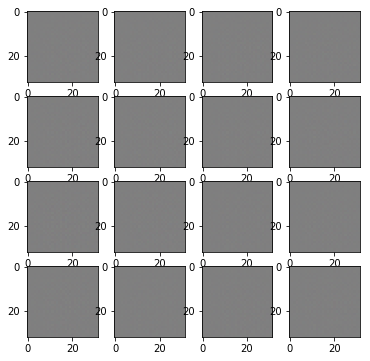

(32, 32, 3)


<Figure size 432x288 with 0 Axes>

In [28]:
generate_test_prediction(generator, 4, random_vector_for_generation)

In [29]:
def train(epochs):
    epoch = 0
    start = time.time()
    for cartoon_images in cartoon_ds:
        train_step(cartoon_images)
        epoch = epoch + 1
        if(epoch%10==0):
            #display.clear_output(wait = True)
            generate_test_prediction(generator, epoch, random_vector_for_generation)
        print ('Time taken for epoch {} is {} sec'.format(epoch, time.time()-start))
        start = time.time()
        if epoch == epochs:
            break

In [30]:
EPOCHS = 100

Time taken for epoch 1 is 40.412896394729614 sec
Time taken for epoch 2 is 1.3597302436828613 sec
Time taken for epoch 3 is 1.3553199768066406 sec
Time taken for epoch 4 is 1.3506758213043213 sec
Time taken for epoch 5 is 1.373521327972412 sec
Time taken for epoch 6 is 1.3853423595428467 sec
Time taken for epoch 7 is 1.3454480171203613 sec
Time taken for epoch 8 is 1.3599984645843506 sec
Time taken for epoch 9 is 1.3459250926971436 sec


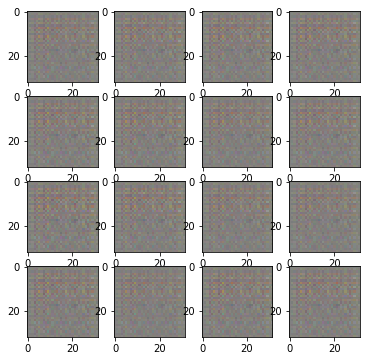

(32, 32, 3)
Time taken for epoch 10 is 2.667111873626709 sec
Time taken for epoch 11 is 1.3474302291870117 sec
Time taken for epoch 12 is 1.3465545177459717 sec
Time taken for epoch 13 is 1.35152268409729 sec
Time taken for epoch 14 is 1.36102294921875 sec
Time taken for epoch 15 is 1.3649756908416748 sec
Time taken for epoch 16 is 1.3721504211425781 sec
Time taken for epoch 17 is 1.3525762557983398 sec
Time taken for epoch 18 is 1.3421123027801514 sec
Time taken for epoch 19 is 1.361729383468628 sec


<Figure size 432x288 with 0 Axes>

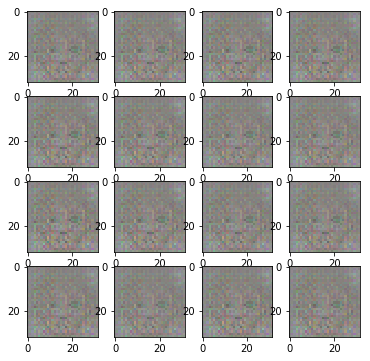

(32, 32, 3)
Time taken for epoch 20 is 2.657876491546631 sec
Time taken for epoch 21 is 1.37788724899292 sec
Time taken for epoch 22 is 1.3484783172607422 sec
Time taken for epoch 23 is 1.358734369277954 sec
Time taken for epoch 24 is 1.3564574718475342 sec
Time taken for epoch 25 is 1.411377191543579 sec
Time taken for epoch 26 is 1.3581979274749756 sec
Time taken for epoch 27 is 1.335153579711914 sec
Time taken for epoch 28 is 1.337265968322754 sec
Time taken for epoch 29 is 1.3333015441894531 sec


<Figure size 432x288 with 0 Axes>

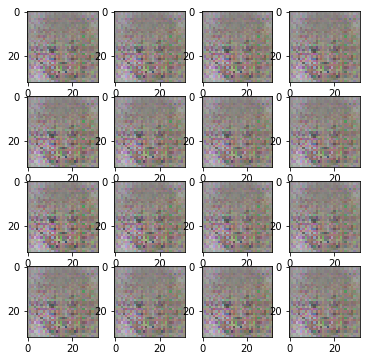

(32, 32, 3)
Time taken for epoch 30 is 2.8496897220611572 sec
Time taken for epoch 31 is 1.3531887531280518 sec
Time taken for epoch 32 is 1.3812100887298584 sec
Time taken for epoch 33 is 1.3419015407562256 sec
Time taken for epoch 34 is 1.3423235416412354 sec
Time taken for epoch 35 is 1.3625211715698242 sec
Time taken for epoch 36 is 1.3702106475830078 sec
Time taken for epoch 37 is 1.3524727821350098 sec
Time taken for epoch 38 is 1.3630726337432861 sec
Time taken for epoch 39 is 1.376401424407959 sec


<Figure size 432x288 with 0 Axes>

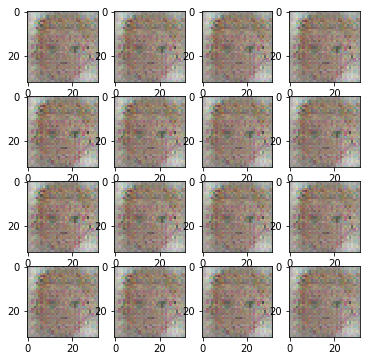

(32, 32, 3)
Time taken for epoch 40 is 2.677767038345337 sec
Time taken for epoch 41 is 1.35957932472229 sec
Time taken for epoch 42 is 1.3632581233978271 sec
Time taken for epoch 43 is 1.3709285259246826 sec
Time taken for epoch 44 is 1.3595092296600342 sec
Time taken for epoch 45 is 1.3876121044158936 sec
Time taken for epoch 46 is 1.3403778076171875 sec
Time taken for epoch 47 is 1.339569091796875 sec
Time taken for epoch 48 is 1.344468593597412 sec
Time taken for epoch 49 is 1.351184606552124 sec


<Figure size 432x288 with 0 Axes>

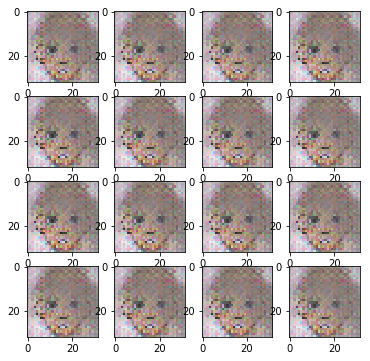

(32, 32, 3)
Time taken for epoch 50 is 2.6353766918182373 sec
Time taken for epoch 51 is 1.374587059020996 sec
Time taken for epoch 52 is 1.346914529800415 sec
Time taken for epoch 53 is 1.3481361865997314 sec
Time taken for epoch 54 is 1.4181373119354248 sec
Time taken for epoch 55 is 1.3374378681182861 sec
Time taken for epoch 56 is 1.3546454906463623 sec
Time taken for epoch 57 is 1.3184797763824463 sec
Time taken for epoch 58 is 1.3670544624328613 sec
Time taken for epoch 59 is 1.3321654796600342 sec


<Figure size 432x288 with 0 Axes>

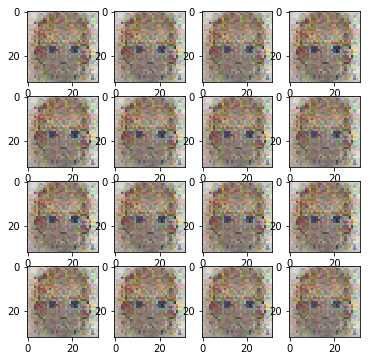

(32, 32, 3)
Time taken for epoch 60 is 2.6300156116485596 sec
Time taken for epoch 61 is 1.3476884365081787 sec
Time taken for epoch 62 is 1.3441681861877441 sec
Time taken for epoch 63 is 1.3300669193267822 sec
Time taken for epoch 64 is 1.3238258361816406 sec
Time taken for epoch 65 is 1.3669631481170654 sec
Time taken for epoch 66 is 1.3364214897155762 sec
Time taken for epoch 67 is 1.338864803314209 sec
Time taken for epoch 68 is 1.3470511436462402 sec
Time taken for epoch 69 is 1.3432502746582031 sec


<Figure size 432x288 with 0 Axes>

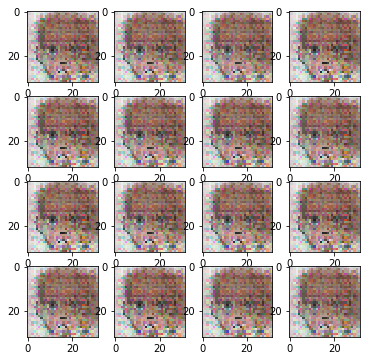

(32, 32, 3)
Time taken for epoch 70 is 2.603438138961792 sec
Time taken for epoch 71 is 1.3314948081970215 sec
Time taken for epoch 72 is 1.3335225582122803 sec
Time taken for epoch 73 is 1.3417248725891113 sec
Time taken for epoch 74 is 1.323085069656372 sec
Time taken for epoch 75 is 1.3363564014434814 sec
Time taken for epoch 76 is 1.3386313915252686 sec
Time taken for epoch 77 is 1.3202576637268066 sec
Time taken for epoch 78 is 1.3323984146118164 sec
Time taken for epoch 79 is 1.3403816223144531 sec


<Figure size 432x288 with 0 Axes>

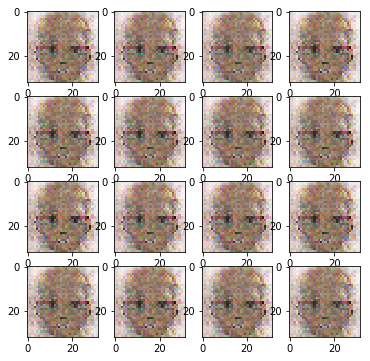

(32, 32, 3)
Time taken for epoch 80 is 2.8860950469970703 sec
Time taken for epoch 81 is 1.3525454998016357 sec
Time taken for epoch 82 is 1.339998483657837 sec
Time taken for epoch 83 is 1.3307483196258545 sec
Time taken for epoch 84 is 1.307661533355713 sec
Time taken for epoch 85 is 1.3366320133209229 sec
Time taken for epoch 86 is 1.3721158504486084 sec
Time taken for epoch 87 is 1.338890552520752 sec
Time taken for epoch 88 is 1.3247346878051758 sec
Time taken for epoch 89 is 1.340257167816162 sec


<Figure size 432x288 with 0 Axes>

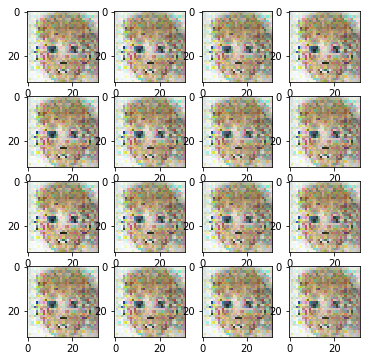

(32, 32, 3)
Time taken for epoch 90 is 2.610801935195923 sec
Time taken for epoch 91 is 1.3586690425872803 sec
Time taken for epoch 92 is 1.3349931240081787 sec
Time taken for epoch 93 is 1.3533844947814941 sec
Time taken for epoch 94 is 1.3231897354125977 sec
Time taken for epoch 95 is 1.3515949249267578 sec
Time taken for epoch 96 is 1.4059467315673828 sec
Time taken for epoch 97 is 1.412449836730957 sec
Time taken for epoch 98 is 1.3397486209869385 sec
Time taken for epoch 99 is 1.3508872985839844 sec


<Figure size 432x288 with 0 Axes>

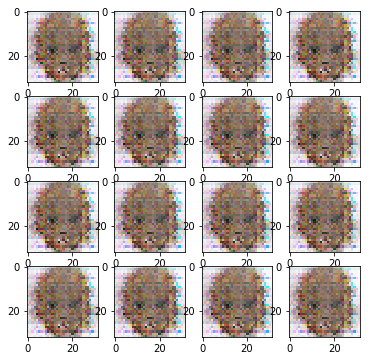

(32, 32, 3)
Time taken for epoch 100 is 2.64552903175354 sec
CPU times: user 5min 47s, sys: 11.7 s, total: 5min 58s
Wall time: 3min 7s


<Figure size 432x288 with 0 Axes>

In [31]:
%%time
train(EPOCHS)

In [32]:
gen_out = generator(random_vector_for_generation)
print(np.max(gen_out))
print(np.min(gen_out))

0.9964997
-0.89625704


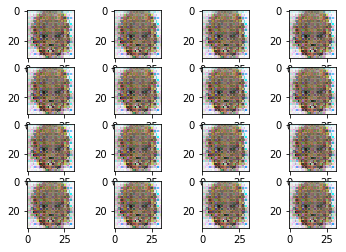

In [33]:
for n,image in enumerate(gen_out):
    image = image/2 + 0.5
    plt.subplot(4,4,n+1)
    plt.imshow(image)
    plt.grid(False)